<a href="https://colab.research.google.com/github/KaiKevinLiao/Macro-Tutorial/blob/main/Macro_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar, minimize, fsolve
from scipy.interpolate import interp1d

In [ ]:
np.zeros((3,3))

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [ ]:
np.ones((3,3))

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [ ]:
np.diag([1,2,3])

array([[1, 0, 0],
       [0, 2, 0],
       [0, 0, 3]])

In [ ]:
x = np.array([1,2,3,4,5,6])
x

array([1, 2, 3, 4, 5, 6])

In [ ]:
x = x.reshape((2,3))
x

array([[1, 2, 3],
       [4, 5, 6]])

In [ ]:
x.T

array([[1, 4],
       [2, 5],
       [3, 6]])

In [ ]:
np.array([1,2,3,4,5,6]).reshape((2,3)).T

array([[1, 4],
       [2, 5],
       [3, 6]])

In [ ]:
x = np.diag([1,2,3])
np.linalg.inv(x)

array([[1.        , 0.        , 0.        ],
       [0.        , 0.5       , 0.        ],
       [0.        , 0.        , 0.33333333]])

In [ ]:
x = np.ones((2,3)) * 2
y = np.ones((2,3)) * 3
np.concatenate((x, y), axis=1)

array([[2., 2., 2., 3., 3., 3.],
       [2., 2., 2., 3., 3., 3.]])

In [ ]:
np.concatenate((x, y), axis=0)

array([[2., 2., 2.],
       [2., 2., 2.],
       [3., 3., 3.],
       [3., 3., 3.]])

In [ ]:
x + y

array([[5., 5., 5.],
       [5., 5., 5.]])

In [ ]:
x * y

array([[6., 6., 6.],
       [6., 6., 6.]])

In [ ]:
x @ y.T

array([[18., 18.],
       [18., 18.]])

In [ ]:
x

array([[2., 2., 2.],
       [2., 2., 2.]])

In [ ]:
np.matlib.repmat(x,2, 1)

array([[2., 2., 2.],
       [2., 2., 2.],
       [2., 2., 2.],
       [2., 2., 2.]])

### How to use repmat to avoid writing loops

Suppose there are 5 product and 10 consumers. Product $j$ has a characteristic $x_j$, consumer $i$ has characteristic $z_i$. Assume the value of the product $j$ to the consumer $i$ is $x_j * z_i$. How to construct the 5 * 10 value matrix?

In [ ]:
X = np.array([i for i in range(5)])
Z = np.array([i for i in range(10)])
V = np.zeros((5,10))

for i in range(len(X)):
  for j in range(len(Z)):
    V[i, j] = X[i] * Z[j]

V

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
       [ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18.],
       [ 0.,  3.,  6.,  9., 12., 15., 18., 21., 24., 27.],
       [ 0.,  4.,  8., 12., 16., 20., 24., 28., 32., 36.]])

In [ ]:
np.matlib.repmat(X.reshape((5,1)),1,10) * np.matlib.repmat(Z.reshape((1,10)),5,1)

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18],
       [ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27],
       [ 0,  4,  8, 12, 16, 20, 24, 28, 32, 36]])

## Dynamic programming (cake-eating problem)
The following codes are created by Prof. Kerry Back for BUSI 520

maximize

$$\sum_{t=0}^\infty \delta^t \sqrt{c_t}$$

subject to

$$\sum_{t=0}^\infty c_t  \leq 1$$

Dynamic programming: value function $v$, state variable $x$ with $x_{t+1} = x_t - c_t$, $x_0=1$.  Bellman equation:

$$v(x) = \max_{0 \le c \le x} \sqrt{c} + \delta v(x-c)$$

### Value function iteration

Start with an initial guess for $v$ on a grid.  Use it as the right-hand side of the Bellman equation.  Compute the max to get the left-hand side.  Use the new $v$ on the right-hand side and repeat until convergence.


A small problem is that to compute the max, we want $v(x-c)$ defined for all $c\leq x$, not just on the grid.  So, we interpolate linearly between grid points.

In [ ]:
delta = 0.9    # discount rate
grid = np.linspace(0, 1, 100)

def rhs(v, x):

    # extend v to be defined on [0,1]
    v = interp1d(grid, v)

    # write maximization objective as minimization objective
    obj = lambda c: - np.sqrt(c) - delta * v(x-c)

    # solve the minimization problem
    result = minimize_scalar(obj, bounds=(0, x), method="bounded")

    # return the value at the optimum
    return - result.fun

Now we can define the contraction map.

In [ ]:
def cmap(v):
   
    # convert the rhs function to operate on an array (in x)
    rhs_u = np.frompyfunc(lambda x: rhs(v,x), 1, 1)

    # apply the rhs function to get the LHS of Bellman equation
    newv = rhs_u(grid)

    # return the new v and also how far apart the two v's are
    return newv, np.mean((newv-v)**2)

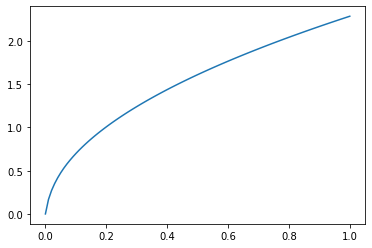

In [ ]:
# initialize the iteration
v = np.zeros(len(grid))

# set tolerance and maximum number of iterations
tol = 1.0e-10
maxiters = 100

# initialize error and counter for iterations
err = 1
iter = 0

# run the loop
while (err > tol) and (iter < maxiters):
    v, err = cmap(v)
    iter += 1

plt.plot(grid, v)